In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housing/target.csv
/kaggle/input/housing/train.csv
/kaggle/input/housing/test.csv
/kaggle/input/housing/AmesHousing.csv


# Explore and load the data 



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


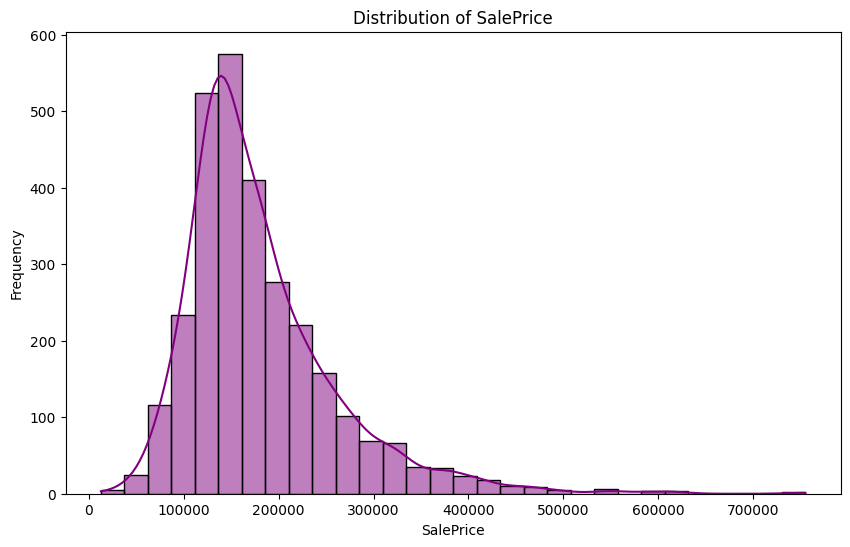


Top Correlations with SalePrice:
SalePrice         1.000000
Overall Qual      0.799262
Gr Liv Area       0.706780
Garage Cars       0.647877
Garage Area       0.640401
Total Bsmt SF     0.632280
1st Flr SF        0.621676
Year Built        0.558426
Full Bath         0.545604
Year Remod/Add    0.532974
Name: SalePrice, dtype: float64


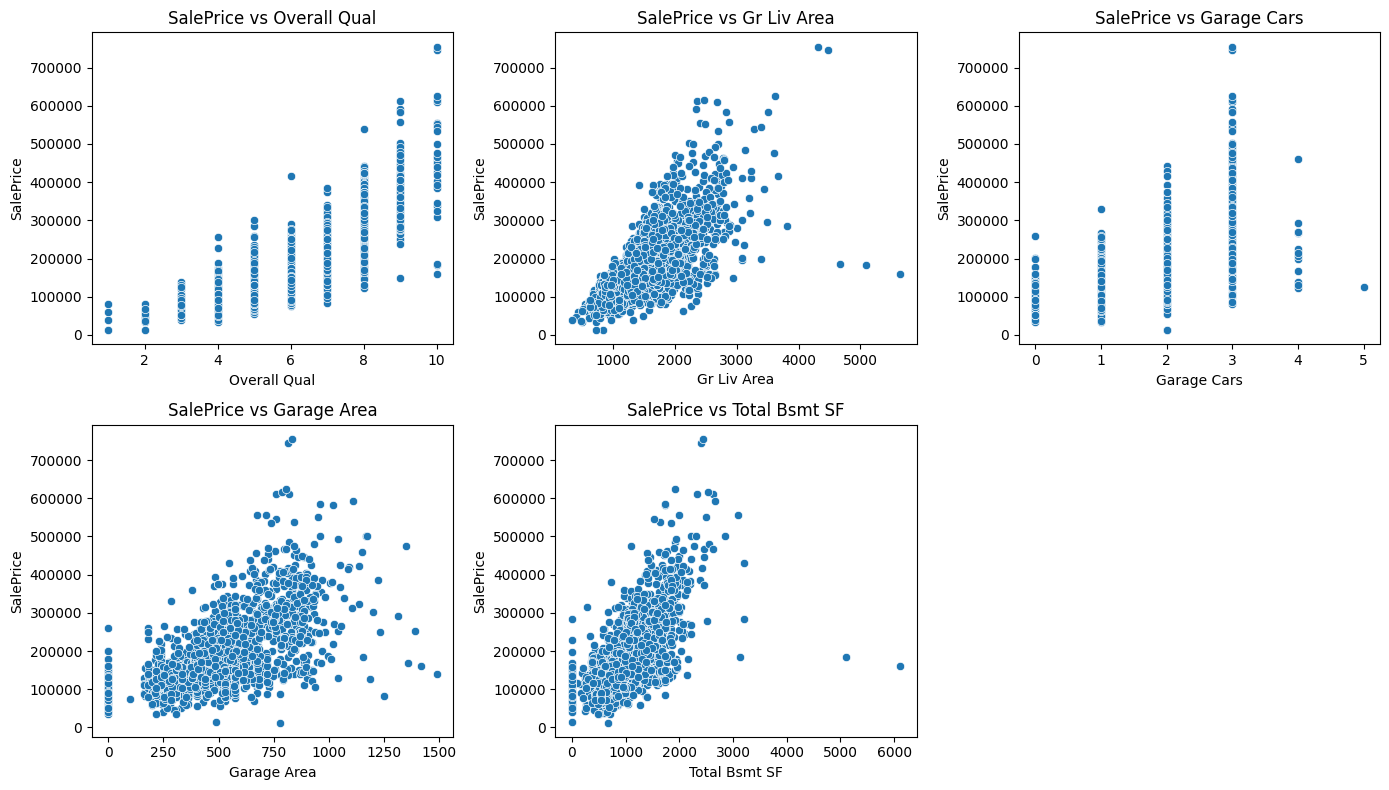

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Ames Housing dataset
data_path = "/kaggle/input/housing/AmesHousing.csv" 
df = pd.read_csv(data_path)

# Display basic information about the dataset
print("Dataset Info:")
df.info()
print("\nDataset Shape:", df.shape)

# Display the first few rows of the dataset
print("\nSample Rows:")
print(df.head(3))

# Check for missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
print("\nMissing Values:")
print(missing_values[missing_values > 0])

# Visualize target variable distribution (SalePrice)
plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], kde=True, bins=30, color='purple')
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

# Ensure only numeric columns are used
numeric_df = df.select_dtypes(include=['number'])

# Check correlations with SalePrice
correlations = numeric_df.corr()['SalePrice'].sort_values(ascending=False)
print("\nTop Correlations with SalePrice:")
print(correlations.head(10))

# Visualize correlations of top 5 features with SalePrice
top_features = correlations.index[1:6]  # Exclude SalePrice itself
plt.figure(figsize=(14, 8))
for i, feature in enumerate(top_features, start=1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=df[feature], y=df['SalePrice'])
    plt.title(f"SalePrice vs {feature}")
plt.tight_layout()
plt.show()

# Data Preprocessing 

Okay, the data looks good! The main preprocessing step will be dealing with the missing data values. I will also need to encode the categorical values because I want to use the RandomForestRegressor model which expect numeric values for training. 

In [11]:
# Data Preprocessing = Missing data values 

train_path = "/kaggle/input/housing/train.csv" 
train_df = pd.read_csv(train_path)

# Handle categorical columns where NA really means 'None'
fill_none_features = ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu', 
                      'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 
                      'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 
                      'Bsmt Qual', 'Bsmt Cond', 'Mas Vnr Type']

train_df[fill_none_features] = train_df[fill_none_features].fillna('None')

# Handle numerical columns where NA really means 0 
fill_zero_features = ['Mas Vnr Area', 'Garage Yr Blt', 'Garage Cars', 
                      'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 
                      'Total Bsmt SF', 'Garage Area', 'Bsmt Full Bath', 
                      'Bsmt Half Bath']

train_df[fill_zero_features] = train_df[fill_zero_features].fillna(0)

# Handle numerical columns where NA can be estimated
train_df['Lot Frontage'] = train_df['Lot Frontage'].fillna(train_df['Lot Frontage'].median())
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])

# Drop features with too much missing data 
train_df = train_df.drop(['Pool QC', 'Misc Feature'], axis=1)

# Verify missing values are resolved
print(train_df.isnull().sum())

Order             0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage      0
                 ..
Mo Sold           0
Yr Sold           0
Sale Type         0
Sale Condition    0
SalePrice         0
Length: 80, dtype: int64


# Build and Train the model 
For this supervised learning project, I will start with building and training a Random Forest model. 

R² Score: 0.8759256546856534


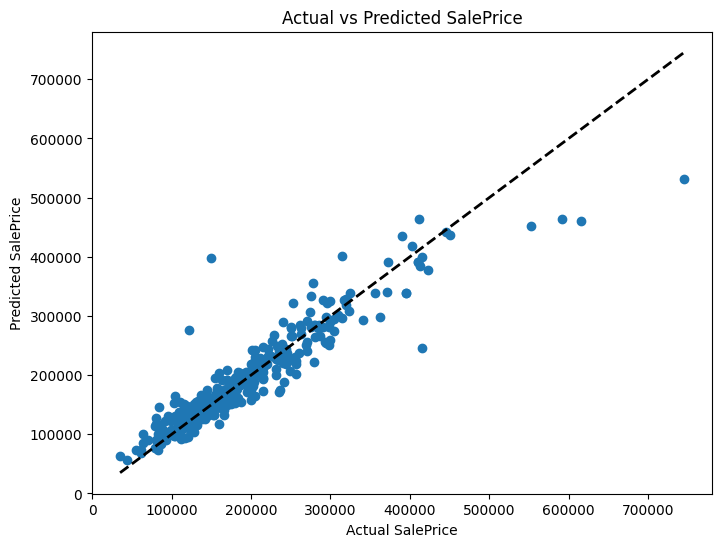

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Specify features (X) and target (y)
X = train_df.drop(columns=['SalePrice'])  
y = train_df['SalePrice']  

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns 

# Data Preprocessing = Encoding 
# Define a transformer for one-hot encoding with handle_unknown='ignore'
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns) 
    ],
    remainder='passthrough'  # Keep the numeric columns as they are
)

# Step 1: Split into train and validation sets 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12)

# Step 2: Create a pipeline that first applies encoding and then trains a random forest model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=12))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = model_pipeline.predict(X_val)

# Evaluate the model
r2 = r2_score(y_val, y_pred)
print(f"R² Score: {r2}")

# Plot actual vs. predicted prices
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'k--', lw=2)  # Line for perfect prediction
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice')
plt.show()

# Try the model against the test data 
That's a pretty solid R2 score! Let's see how it does with the test data next. The test data needs to run through the same preprocessing steps 

In [21]:
# Load the test set
test_path = "/kaggle/input/housing/test.csv"
test_df = pd.read_csv(test_path)

# Handle categorical columns where NA really means 'None'
test_df[fill_none_features] = test_df[fill_none_features].fillna('None')

# Handle numerical columns where NA really means 0 
test_df[fill_zero_features] = test_df[fill_zero_features].fillna(0)

# Handle numerical columns where NA can be estimated
test_df['Lot Frontage'] = test_df['Lot Frontage'].fillna(train_df['Lot Frontage'].median())  # Using train median
test_df['Electrical'] = test_df['Electrical'].fillna(train_df['Electrical'].mode()[0])  # Using train mode

# Drop features with too much missing data (same as the training set)
test_df = test_df.drop(['Pool QC', 'Misc Feature'], axis=1)

# Verify no missing values after preprocessing
print(test_df.isnull().sum())


Order             0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage      0
                 ..
Misc Val          0
Mo Sold           0
Yr Sold           0
Sale Type         0
Sale Condition    0
Length: 79, dtype: int64


Test Set - R²: 0.9001003934715324


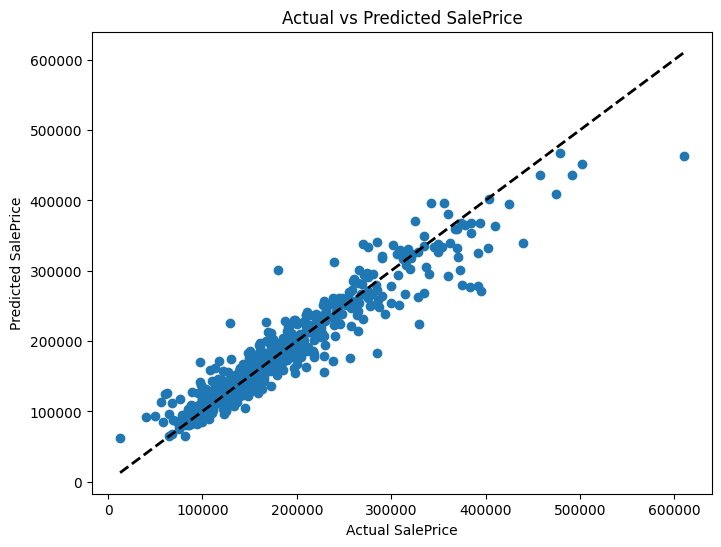

In [34]:
# Make predictions on the test set
y_test_pred = model_pipeline.predict(test_df)

# Load target.csv 
target_path = "/kaggle/input/housing/target.csv"
target_df = pd.read_csv(target_path)

# Get the actual target values for comparison
y_test_actual = target_df['SalePrice']

# Evaluate the model on the test set
r2_test = r2_score(y_test_actual, y_test_pred)
print(f"Test Set - R²: {r2_test}")

# Plot actual vs. predicted prices
plt.figure(figsize=(8,6))
plt.scatter(y_test_actual, y_test_pred)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'k--', lw=2)  # Line for perfect prediction
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice')
plt.show()

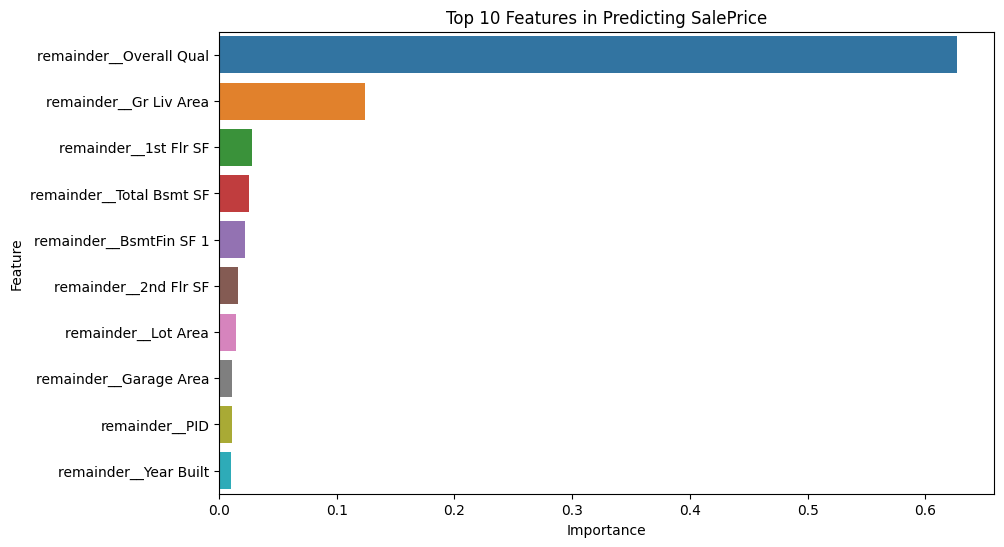

In [31]:
# Evaluation - which features helped give us these results? 

# Get the feature importances
importances = model_pipeline.named_steps['regressor'].feature_importances_

# Get feature names from one-hot encoded categorical features
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for sorting by importance
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance in descending order and select top N features
top_n = 10  
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).head(top_n)

# Plot the top N feature importances
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title(f'Top {top_n} Features in Predicting SalePrice')
plt.show()
